In [1]:
#helps to run cells withou restarting the whole notebook after .py files were updated
%load_ext autoreload
%autoreload 2

# Description

### In this notebook we compute values of correlation between each cluster, sentiment and stocks values. It consists of two parts. In the first part we compute correlation for the embeddings that kept stopwords and in the second part the embedding that removed them. We also generated the wordcloud to showcase the most popular words in the top clusters. 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import correlation #check correlation.py file
from tqdm import tqdm
import data_preprocessing; #check data_preprocessing.py file

### Read all clustered and sentimented files

In [5]:
folder = "files/"
clusters_w_sw = pd.read_csv(folder + "clusterized_tweets_with_stopwords.csv")
clusters_no_sw = pd.read_csv(folder + "clusterized_tweets_without_stopwords.csv")
sentiments_w_sw = pd.read_csv(folder + "sentimented_tweets_with_stopwords.csv")
sentiments_no_sw = pd.read_csv(folder + "sentimented_tweets_without_stopwords.csv")
stocks = pd.read_csv(folder + "clean_stocks.csv")
clusters_w_sw.date = pd.to_datetime(clusters_w_sw.date)
clusters_no_sw.date = pd.to_datetime(clusters_no_sw.date)
sentiments_w_sw.date = pd.to_datetime(sentiments_w_sw.date)
sentiments_no_sw.date = pd.to_datetime(sentiments_no_sw.date)
stocks.date = pd.to_datetime(stocks.date)


In [6]:
#function that combines three dataframes into one 
def combine_dataframes(clusters, sentiments):
    merged = pd.merge(clusters, sentiments, on = ['date','tweet', 'language', 
    'hashtags', 'cashtags',
    'link', 'retweet', 'nlikes', 
    'nreplies', 'nretweets', 'reply_to'], how = 'inner')
    merged = data_preprocessing.cut_dates(merged)
    merged['interactions'] = merged['nlikes'] + merged['nreplies'] + merged['nretweets']
    merged = merged.drop(columns=['nlikes', 'nreplies', 'nretweets'])
    popular = merged.groupby('date').max('interactions').merge(merged[['date', 'tweet']], on = 'date', how = 'right')
    popular.date = popular.date.dt.normalize()
    joined = pd.merge(popular, stocks, on = 'date', how = 'inner')
    return joined

## Analysis of tweets with stopwords

In [7]:
combined_w_sw = combine_dataframes(clusters_w_sw, sentiments_w_sw)

### Now we compute the cramer's coefficient for the combination of the following parameters:

### Cluster methods = ['cluster_use_default', 'cluster_mpnet_default', 'cluster_minilm_default', 'cluster_distilbert_default', 'cluster_use_dbcv', 'cluster_mpnet_dbcv', 'cluster_minilm_dbcv', 'cluster_distilbert_dbcv']

### Sentiment methods  = ['textblob_sentiment', 'bertweet_sentiment', 'distilbert_sentiment']

### Percent change = [0,0.5,1,1.5,2]

### Delay = [1,2,3]

### Here percent change is the value by which we identify the 0 value in stocks changes. For instance if percent change = 0.5, we indicate stocks changes with 0 if it increased or decreased no more than 0.5. Delay value indicates the lag in stock changes by days. In addition we calculate cramer's coefficient for every cluster defined by cluster method. At the end we get 3267 combinations of these params

In [8]:
methods_w_sw = ['cluster_use_default', 'cluster_mpnet_default', 'cluster_minilm_default', 'cluster_distilbert_default', 
'cluster_use_dbcv', 'cluster_mpnet_dbcv', 'cluster_minilm_dbcv', 'cluster_distilbert_dbcv'] #columns that have cluster indexes for different methods
cramer_w_sw = correlation.find_correlation(combined_w_sw, methods_w_sw).sort_values('cramer', ascending=False).reset_index(drop = True) #find correlation
cramer_w_sw[['size']] = ''
for i in tqdm(range(0, cramer_w_sw.shape[0])):
    check = combined_w_sw.loc[combined_w_sw[cramer_w_sw.method[i]] == cramer_w_sw.cluster[i]]
    cramer_w_sw['size'][i] = check.shape[0]
cramer_w_sw

  0%|          | 0/3267 [00:00<?, ?it/s]/home/maksat.kengeskanov/.conda/envs/ml_project/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 3267/3267 [00:02<00:00, 1443.27it/s]


,method,cluster,type,cramer,percent_change,delay,size
0,cluster_distilbert_default,7,textblob_sentiment,0.41622,1,1,32
1,cluster_distilbert_default,9,bertweet_sentiment,0.36535,0,1,34
2,cluster_minilm_default,0,textblob_sentiment,0.35717,0,3,40
3,cluster_minilm_default,24,textblob_sentiment,0.35390,0,1,41
4,cluster_minilm_default,14,textblob_sentiment,0.35203,1.5,3,46
...,...,...,...,...,...,...,...
3262,cluster_use_default,5,bertweet_sentiment,0.00000,2,1,52
3263,cluster_use_default,5,bertweet_sentiment,0.00000,0,2,52
3264,cluster_minilm_default,29,distilbert_sentiment,0.00000,0,3,61
3265,cluster_minilm_default,29,distilbert_sentiment,0.00000,0,2,61


### We were able to get the correlation value of 0.41622 but we see that dataset consists of 32 tweets only. This is unacceptable for the correlation identification. We need to find some balance between tweet sizes and the Cramer's coefficient. Below we show the most common words for different combinations of these variables. 

Cramer's coefficient = 0.41622, Percent Change = 1, Delay = 1, Size = 32
dict_keys(['Texas', 'LA', 'South', 'beautiful', 'place', 'weather', 'tonight', 'amp', 'day', 'Awesome', 'family', 'fun', 'Hope', 'Time', 'Great', 'car', 'stormy', 'Shortville', 'trip', 'Boca', 'way', 'Went', 'Iceland', 'Sat', 'ride', 'bumper', 'ice', 'country', 'Vlad', 'rink', 'Van', 'Nuys', 'passed', 'called', 'Sugar', 'Shack', 'Louisiana', 'swamp', 'wonder', 'happens', 'Huge', 'tornadoes', 'tossing', 'truck', 'trailers', 'air', 'people', 'ok', 'NYC', 'premiere'])


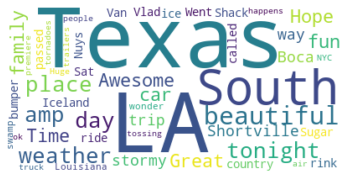

Cramer's coefficient = 0.36535, Percent Change = 0, Delay = 1, Size = 34
dict_keys(['Neuralink', 'will', 's', 'amp', 'brain', 't', 'Yes', 'Neuro Skeptic', 'one', 'flcnhvy', 'neural net', 'high', 'AI', 'think', 'important', 'term', 'Don', 'several', 'precision', 'human', 'year', 'make', 'second', 'shravantr', 'won', 'computer', 'soon', 'Long', 'waitbutwhy', 'time', 'neural', 'product', 'far', 'though', 'similar', 'd', 'chips', 'software', 'machine', 'solution', 'imo', 'orders', 'magnitude', 'CathieDWood', 'ARKInvest', 'Utah', 'Array', 'already', 'ultimately', 'lost'])


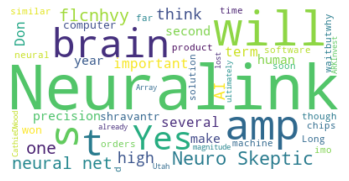

Cramer's coefficient = 0.35717, Percent Change = 0, Delay = 3, Size = 40
dict_keys(['ID AA', 'AA Carmack', 'soumiksf', 's', 'work', 'Must', 'hard', 'impact', 'engine', 'Even', 'better', 'good', 'hope', 'big', 'yup', 'mmeijeri', 'Def', 't', 'YStijd', 'C', 'PPathole', 'flcnhvy', 'amp', 'Yeah', 'Zog', 'Fot', 'Pik', 'samiralyateem', 'jgrano', 'choice', 'Entry', 'velocity', 'high', 'precision', 'landing', 'N', 'thrusters', 'alone', 'aero', 'surfaces', 'pitch', 'trim', 'Dragon', 'something', 'long', 'Falcon', 'Tks', 'Turns', 'recovered', 'video'])


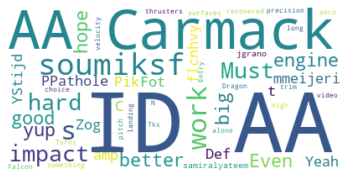

In [9]:
print("Cramer's coefficient = 0.41622, Percent Change = 1, Delay = 1, Size = 32")
correlation.generate_wordcloud(combined_w_sw, 'cluster_distilbert_default', 7)
print("Cramer's coefficient = 0.36535, Percent Change = 0, Delay = 1, Size = 34")
correlation.generate_wordcloud(combined_w_sw, 'cluster_distilbert_default', 9)
print("Cramer's coefficient = 0.35717, Percent Change = 0, Delay = 3, Size = 40")
correlation.generate_wordcloud(combined_w_sw, 'cluster_minilm_default', 0)

### We see that none of the top clusters above are about tesla. They have high correlation coefficient by coincidence. Now let's the clusters that are actually about tesla, these clusters have bigger size as we show below

In [10]:
cramer_w_sw_sorted_size = cramer_w_sw.sort_values('size', ascending=False).reset_index(drop = True)
cramer_w_sw_sorted_size = cramer_w_sw_sorted_size.loc[(cramer_w_sw_sorted_size['size'] < 10000) & (cramer_w_sw_sorted_size['cluster'] != -1) &
(cramer_w_sw_sorted_size['cramer']>0)]
cramer_w_sw_sorted_size.head(25)

,method,cluster,type,cramer,percent_change,delay,size
200,cluster_distilbert_default,10,textblob_sentiment,0.01772,0,2,3182
201,cluster_distilbert_default,10,bertweet_sentiment,0.01769,0.5,1,3182
205,cluster_distilbert_default,10,textblob_sentiment,0.00306,1,1,3182
211,cluster_distilbert_default,10,bertweet_sentiment,0.00964,0.5,2,3182
212,cluster_distilbert_default,10,textblob_sentiment,0.01596,1,3,3182
213,cluster_distilbert_default,10,textblob_sentiment,0.01530,0,1,3182
218,cluster_distilbert_default,10,textblob_sentiment,0.01844,1,2,3182
221,cluster_distilbert_default,10,textblob_sentiment,0.01236,0.5,1,3182
224,cluster_distilbert_default,10,bertweet_sentiment,0.01896,1,2,3182
231,cluster_mpnet_default,5,textblob_sentiment,0.01469,0.5,3,3167


Cramer's coefficient = 0.01772, Percent Change = 0, Delay = 2, Size = 3182
dict_keys(['Tesla', 'amp', 'will', 'car', 's', 'Model', 'Model S', 'teslaownersSV', 'production', 'year', 'make', 'new', 'V', 'good', 'Autopilot', 'time', 'Thank', 'need', 'great', 'work', 'U', 'people', 'week', 're', 'Ye', 'month', 'now', 'soon', 'software', 'cost', 'probably', 'price', 'better', 'flcnhvy', 'DMC Ryan', 'first', 'day', 'many', 'one', 'lot', 'much', 'high', 'even', 'sure', 'part', 'Maybe', 'battery', 'way', 'going', 'Teslarati'])


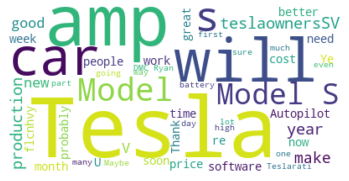

Cramer's coefficient = 0.01469, Percent Change = 0.5, Delay = 3, Size = 3167
dict_keys(['Tesla', 'amp', 'will', 'car', 's', 'teslaownersSV', 'Model', 'Model S', 'year', 'Teslarati', 'production', 'time', 'make', 'new', 'Yes', 'Thank', 'Autopilot', 'V', 'great', 'U', 'good', 'need', 're', 'work', 'month', 'week', 'now', 'better', 'software', 'many', 'lot', 'price', 'one', 'people', 'soon', 'day', 'probably', 'first', 'cost', 'much', 'battery', 'team', 'even', 'part', 'sure', 'high', 'way', 'going', 'actually', 'coming'])


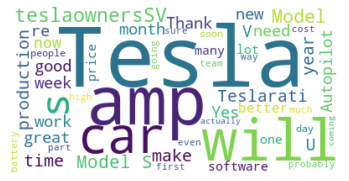

Cramer's coefficient = 0.01089, Percent Change = 1, Delay = 1, Size = 3097
dict_keys(['Tesla', 'amp', 'will', 'car', 's', 'production', 'year', 'Model S', 'make', 'U', 'time', 'new', 'people', 'good', 'work', 'Model', 'need', 'many', 'Autopilot', 're', 'V', 'great', 'week', 'better', 'Thank', 'software', 'month', 'first', 'cost', 'now', 'high', 'one', 'even', 'lot', 'day', 'soon', 'actually', 'price', 'much', 'Ye', 'team', 'way', 'hard', 'working', 'probably', 'PPathole', 'world', 'going', 'flcnhvy', 'm'])


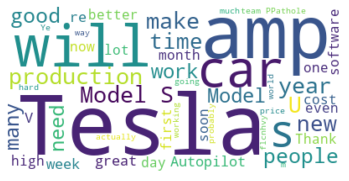

In [11]:
print("Cramer's coefficient = 0.01772, Percent Change = 0, Delay = 2, Size = 3182")
correlation.generate_wordcloud(combined_w_sw, 'cluster_distilbert_default', 10)
print("Cramer's coefficient = 0.01469, Percent Change = 0.5, Delay = 3, Size = 3167")
correlation.generate_wordcloud(combined_w_sw, 'cluster_mpnet_default', 5)
print("Cramer's coefficient = 0.01089, Percent Change = 1, Delay = 1, Size = 3097")
correlation.generate_wordcloud(combined_w_sw, 'cluster_use_default', 2)

### As we can see these cluster are indeed about Tesla, however the correlation coefficient is very low, therefore we can say that there is no correlation

## Analysis of tweets without stopwords

In [12]:
from IPython.display import display
combined_no_sw = combine_dataframes(clusters_no_sw, sentiments_no_sw)
methods_no_sw = ['cluster_bow_default','cluster_tfidf_default','cluster_word2vec_default', 'cluster_bow_dbcv', 'cluster_tfidf_dbcv', 'cluster_word2vec_dbcv']
cramer_no_sw = correlation.find_correlation(combined_no_sw, methods_no_sw).sort_values('cramer', ascending=False).reset_index(drop = True)
cramer_no_sw[['size']] = ''
for i in tqdm(range(0, cramer_no_sw.shape[0])):
    check = combined_no_sw.loc[combined_no_sw[cramer_no_sw.method[i]] == cramer_no_sw.cluster[i]]
    cramer_no_sw['size'][i] = check.shape[0]
cramer_no_sw

/home/maksat.kengeskanov/Desktop/ML/correlation.py:22: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
  0%|          | 0/1485 [00:00<?, ?it/s]/home/maksat.kengeskanov/.conda/envs/ml_project/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 1485/1485 [00:01<00:00, 1378.47it/s]


,method,cluster,type,cramer,percent_change,delay,size
0,cluster_word2vec_default,10,bertweet_sentiment,0.99034,0,1,54
1,cluster_word2vec_default,10,bertweet_sentiment,0.67937,0,2,54
2,cluster_word2vec_dbcv,6,distilbert_sentiment,0.67881,0,2,53
3,cluster_word2vec_default,2,textblob_sentiment,0.67342,0,2,45
4,cluster_word2vec_default,10,bertweet_sentiment,0.53709,0.5,2,54
...,...,...,...,...,...,...,...
1480,cluster_word2vec_dbcv,0,textblob_sentiment,NaN,1.5,3,37
1481,cluster_word2vec_dbcv,0,textblob_sentiment,NaN,2,3,37
1482,cluster_word2vec_dbcv,0,distilbert_sentiment,NaN,0,1,37
1483,cluster_word2vec_dbcv,0,distilbert_sentiment,NaN,0,2,37


### This table has the combination with the highest correlation coefficient of 0.99 but size of the cluster is only 54, let's see their wordclouds

Cramer's coefficient = 0.99034, Percent Change = 0, Delay = 1, Size = 54
dict_keys(['Great', 'idea', 'game', 'song', 'shot', 'thread', 'interview', 'Great Great', 'name', 'Hack', 'spirit', 'Superdome', 'Awesome', 'rally', '49ers', 'SB47', 'explanation', 'announcement', 'discussion', 'solarbatteries', 'empowering', 'rural', 'communities', 'Whole', 'Fallout', 'series', 'amazing', 'comedy', 'write', 'roasting', 'nuts', 'thanks', 'move', 'meeting', 'verdict', 'Love', 'Brunel', 'first', 'ad', '3Owners', 'conversationstarter', 'summary', 'key', 'points', 'list', 'hotel', 'poem', 'analysis', 'show', 'talking'])


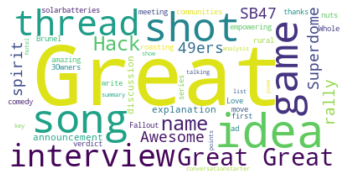

Cramer's coefficient = 0.67881, Percent Change = 0, Delay = 2, Size = 53
dict_keys(['Ok Ok', 'fine', '1matthewgarcia'])


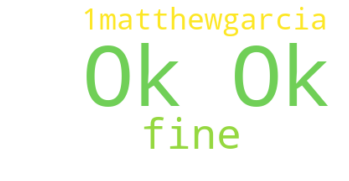

Cramer's coefficient = 0.67342, Percent Change = 0, Delay = 2, Size = 45
dict_keys(['Yes Yes', 'Yeah', 'Losing', 'Absolutely'])


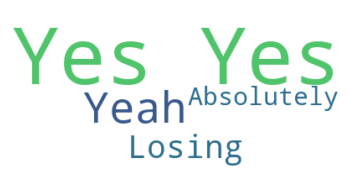

In [238]:
print("Cramer's coefficient = 0.99034, Percent Change = 0, Delay = 1, Size = 54")
correlation.generate_wordcloud(combined_no_sw, 'cluster_word2vec_default', 10)
print("Cramer's coefficient = 0.67881, Percent Change = 0, Delay = 2, Size = 53")
correlation.generate_wordcloud(combined_no_sw, 'cluster_word2vec_dbcv', 6)
print("Cramer's coefficient = 0.67342, Percent Change = 0, Delay = 2, Size = 45")
correlation.generate_wordcloud(combined_no_sw, 'cluster_word2vec_default', 2)

### We see that these clusters don't make sense, again we have coincidence. Let's select the clusters with bigger size

In [13]:
cramer_no_sw_sorted_size = cramer_no_sw.sort_values('size', ascending=False).reset_index(drop = True)
cramer_no_sw_sorted_size = cramer_no_sw_sorted_size.loc[(cramer_no_sw_sorted_size['size'] < 8000) & (cramer_no_sw_sorted_size['cluster'] != -1) &
(cramer_no_sw_sorted_size['cramer']>0)]
cramer_no_sw_sorted_size.head(25)

,method,cluster,type,cramer,percent_change,delay,size
364,cluster_bow_default,2,bertweet_sentiment,0.01863,2,3,434
365,cluster_bow_default,2,textblob_sentiment,0.04842,0.5,1,434
366,cluster_bow_default,2,bertweet_sentiment,0.05474,1.5,2,434
367,cluster_bow_default,2,textblob_sentiment,0.03286,1.5,1,434
370,cluster_bow_default,2,textblob_sentiment,0.04860,1,1,434
374,cluster_bow_default,2,bertweet_sentiment,0.04487,1,2,434
379,cluster_bow_default,2,bertweet_sentiment,0.02537,1.5,3,434
381,cluster_bow_default,2,bertweet_sentiment,0.02564,1,3,434
386,cluster_bow_default,2,bertweet_sentiment,0.03088,2,2,434
389,cluster_bow_default,2,textblob_sentiment,0.02805,2,1,434


Cramer's coefficient = 0.01863, Percent Change = 2, Delay = 3, Size = 434
dict_keys(['Yes Yes', 'amp', 'year', 'good', 'lot', 'much', 'needed', 'next', 'probably', 'first', 'month', 'best', 'maybe', 'improve', 'even', 'take', 'made', 'new', 'Model', 'wont', 'car', 'away', 'every', 'Will', 'work', 'need', 'although', 'think', 'SpaceX', 'many', 'mistake', 'better', 'several', 'energy', 'S', 'bad', 'fast', 'three', 'actually', 'though', 'region', 'go', 'soon', 'material', 'really', 'use', 'already', 'slow', 'Doesnt', 'change'])


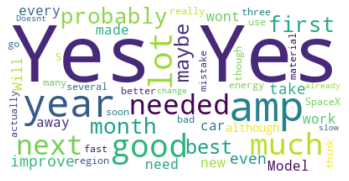

Cramer's coefficient = 0.06954, Percent Change = 0.5, Delay = 3, Size = 391
dict_keys(['Yes Yes', 'amp', 'year', 'lot', 'good', 'month', 'much', 'probably', 'first', 'needed', 'best', 'next', 'improve', 'Will', 'made', 'new', 'Model', 'wont', 'car', 'away', 'even', 'already', 'take', 'need', 'Haha', 'think', 'SpaceX', 'control', 'several', 'energy', 'S', 'huge', 'amount', 'maybe', 'three', 'actually', 'though', 'region', 'go', 'really', 'use', 'hardware', 'Hopefully', 'slow', 'change', 'version', 'point', '3Owners', 'beta', 'work'])


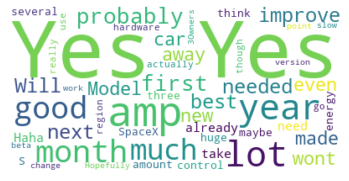

Cramer's coefficient = 0.07703, Percent Change = 2, Delay = 3, Size = 311
dict_keys(['Yes Yes', 'done', 'Um', 'others', 'Tesla', 'gets', 'good', 'even', 'amp', 'way', 'Btw', 'dont', 'think', 'Apple', 'doomed', 'wont', 'unseat', 'Google', '1st', 'place', 'Larry', 'P', 'charge', 'happy', 'hear', 'GM', 'plans', 'develop', 'affordable', 'mile', 'range', 'electric', 'car', 'Right', 'target', 'Hope', '3ll', 'Wikception', 'jointly', 'Radio', 'Flyer', 'trend', 'continues', '4kpixelsyt', '1t', 'addressed', 'fronts', 'judicial', 'legislative', 'executive'])


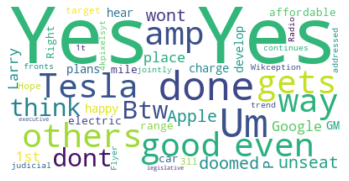

In [14]:
print("Cramer's coefficient = 0.01863, Percent Change = 2, Delay = 3, Size = 434")
correlation.generate_wordcloud(combined_no_sw, 'cluster_bow_default', 2)
print("Cramer's coefficient = 0.06954, Percent Change = 0.5, Delay = 3, Size = 391")
correlation.generate_wordcloud(combined_no_sw, 'cluster_bow_dbcv', 1)
print("Cramer's coefficient = 0.07703, Percent Change = 2, Delay = 3, Size = 311")
correlation.generate_wordcloud(combined_no_sw, 'cluster_tfidf_default', 0)

### We see that some clusters are about Tesla, however the top words are "Yes" for all of them. This means that methods that removed the stopwords, lost some context, therefore aren't good for this task